WE will start with EDA

In [5]:
# Necessary imports

## Data loading, processing and for more
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE # For handling imbalanced data

## Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Set seaborn style because it makes plots look nicer
sns.set()

## Metrics for evaluating models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

## Machine Learning Models
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier # Though not used directly in this notebook, good to have it imported

1.2 Data Loading and Initial Inspection
Now, I'll load my specific dataset, Fraud.csv, from my local Downloads folder. I've learned that Windows file paths with backslashes can cause SyntaxError in Python due to escape characters. To avoid this, I'll use a raw string by prefixing the path with r. This tells Python to treat backslashes literally.

After loading, I'll display the first 5 rows to get a quick glimpse of the data's structure and contents.

In [7]:
# Read the data from my local path
# Using 'r' before the string to handle backslashes in Windows path correctly
data = pd.read_csv(r"C:\Users\shubhangi singh\Downloads\Fraud.csv")

# Display the first 5 rows to see what my data looks like
data.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Based on my head() output, my dataset columns are:

step: Represents the day in the simulation.

type: Type of transaction (e.g., PAYMENT, TRANSFER, CASH_OUT, DEBIT, CASH_IN).

amount: The amount of the transaction.

nameOrig: ID of the originating customer.

oldbalanceOrg: Initial balance of the originating customer.

newbalanceOrg: New balance of the originating customer.

nameDest: ID of the destination (customer or merchant).

oldbalanceDest: Initial balance of the recipient. Note: This is 0 for merchants.

newbalanceDest: New balance of the recipient. Note: This is 0 for merchants.

isFraud: My target variable. Indicates if the transaction is fraudulent (1) or benign (0). This represents transactions made by fraudulent agents specifically to empty accounts via transfer then cash out.

isFlaggedFraud: A flag set by the business model for transfers over 200,000. This is an explicit rule-based flag.

Next, I'll check the column types and look for any missing values using data.info(). This is crucial for understanding the data's quality and what preprocessing steps might be needed.

In [8]:
# Let's look at column types and missing values in data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


There are no missing values (Non-Null Count matches 6362620 for all columns). This is excellent, as it means I don't need to perform any imputation for missing data.

Columns like type, nameOrig, and nameDest are of object type, indicating they are categorical and will need to be encoded later.

isFraud is my target column, and it's an int64, which is good for classification.

1.3 Understanding Fraud Imbalance
Fraud datasets are almost always imbalanced, meaning the number of fraudulent transactions is much smaller than non-fraudulent ones. I'll visualize this imbalance and print the counts to confirm. This imbalance is a critical aspect to address later in my data preprocessing, as it can significantly affect model performance.

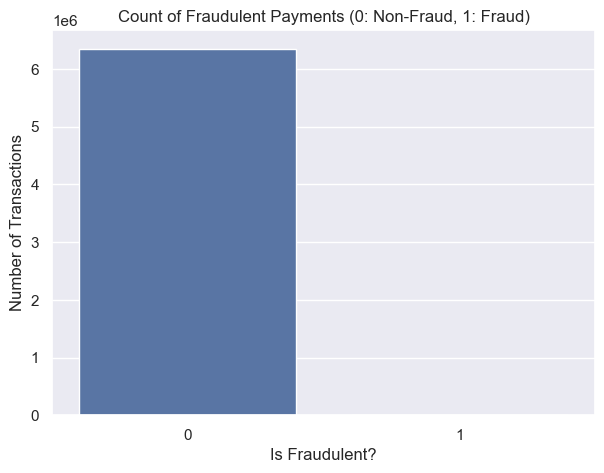

Number of normal examples:  6354407
Number of fraudulent examples:  8213


In [11]:
# Create two dataframes: one for fraud and one for non-fraud data
df_fraud = data.loc[data.isFraud == 1]
df_non_fraud = data.loc[data.isFraud == 0]

# Plot the count of fraudulent vs. non-fraudulent payments
plt.figure(figsize=(7, 5)) # Added figure size for clarity
sns.countplot(x="isFraud", data=data)
plt.title("Count of Fraudulent Payments (0: Non-Fraud, 1: Fraud)")
plt.xlabel("Is Fraudulent?")
plt.ylabel("Number of Transactions")
plt.show()

# Print the exact counts
print("Number of normal examples: ", df_non_fraud.isFraud.count())
print("Number of fraudulent examples: ", df_fraud.isFraud.count())

As expected, my dataset is highly imbalanced! There are significantly more non-fraudulent transactions (over 6 million) compared to fraudulent ones (just over 8 thousand). I'll need to use techniques like SMOTE to handle this imbalance during preprocessing.

1.4 Analyzing Amount and Type by Fraud Status
Now, I'll dive a bit deeper into the amount and type of transactions in relation to fraud. This will help me understand if certain transaction types or amounts are more prone to fraud. Given the description, I expect TRANSFER and CASH_OUT to be highly relevant.

First, I'll look at the mean amount and fraud percentage per transaction type.

In [12]:
# Let's see the mean amount and fraud percent by transaction type
print("Mean feature values per type:")
# Group by 'type' and calculate the mean of 'amount' and 'isFraud'
# Using a list [['amount','isFraud']] for column selection
print(data.groupby('type')[['amount','isFraud']].mean())

Mean feature values per type:
                 amount   isFraud
type                             
CASH_IN   168920.242004  0.000000
CASH_OUT  176273.964346  0.001840
DEBIT       5483.665314  0.000000
PAYMENT    13057.604660  0.000000
TRANSFER  910647.009645  0.007688


This strongly confirms the fraud scheme:

CASH_IN, DEBIT, and PAYMENT transactions show zero fraud. This means fraudulent activities in this dataset are exclusively focused on TRANSFER and CASH_OUT.

TRANSFER has the highest mean amount and the highest isFraud rate (0.79%).

CASH_OUT also has a non-zero isFraud rate (0.19%) and a significant mean amount.

Let's further confirm this by looking at the mean amounts for fraudulent and non-fraudulent transactions, grouped by type. This will show if fraudulent transactions have significantly different average amounts compared to non-fraudulent ones within each type.

In [13]:
# Create two dataframes with fraud and non-fraud data
# Then concatenate their mean amounts grouped by 'type' along with the fraud percentage
pd.concat([df_fraud.groupby('type')['amount'].mean(),
           df_non_fraud.groupby('type')['amount'].mean(),
           data.groupby('type')['isFraud'].mean()*100],
          keys=["Fraudulent Avg Amount","Non-Fraudulent Avg Amount","Percent(%)"],
          axis=1,
          sort=False).sort_values(by=['Non-Fraudulent Avg Amount'])

,Fraudulent Avg Amount,Non-Fraudulent Avg Amount,Percent(%)
type,,,
DEBIT,NaN,5483.665314,0.000000
PAYMENT,NaN,13057.604660,0.000000
CASH_IN,NaN,168920.242004,0.000000
CASH_OUT,1.455103e+06,173917.155751,0.183955
TRANSFER,1.480892e+06,906229.007812,0.768799


This table perfectly aligns with the fraud scheme:

DEBIT, PAYMENT, and CASH_IN have NaN for Fraudulent Avg Amount because there are no fraudulent transactions of these types in the dataset.

For CASH_OUT and TRANSFER types, the average fraudulent amount is indeed significantly higher than the average non-fraudulent amount within those types. This confirms that amount is a very strong indicator of fraud, especially for these two transaction types.

Next, I'll visualize the distribution of amounts across different transaction type using a boxplot. This will show the spread and identify outliers.

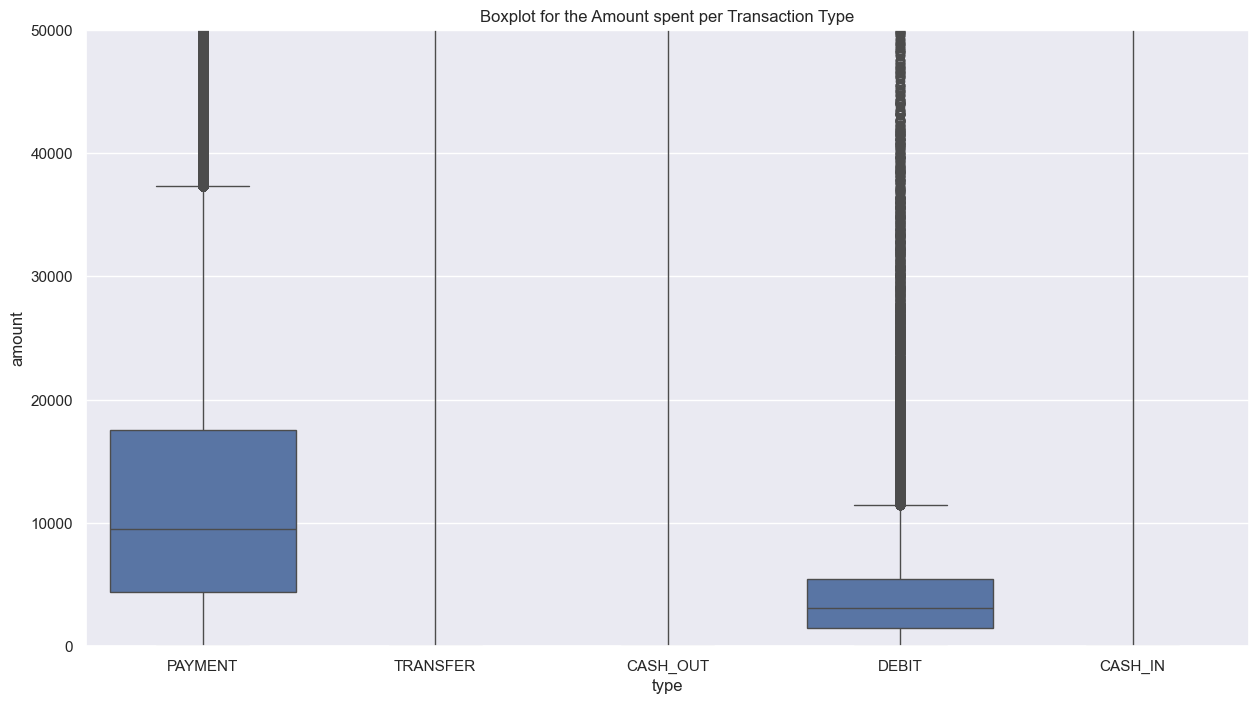

In [14]:
# Plot boxplots of the amounts in different transaction types
plt.figure(figsize=(15,8))
sns.boxplot(x=data.type, y=data.amount)
plt.title("Boxplot for the Amount spent per Transaction Type")
plt.ylim(0, 50000) # Limiting y-axis to focus on typical amounts and see distributions better
plt.show()

My Observations from the Boxplot:

Most transaction types have relatively low amounts, and their distributions are concentrated.

CASH_OUT and TRANSFER types show a much wider range of amounts, and their boxplots indicate the presence of very large transactions, which aligns with the higher average fraudulent amounts observed earlier. I had to set ylim to get a better visual, as the very large outliers would compress the entire plot. This again supports the idea that fraud is linked to these specific transaction types and higher amounts.

Finally, I'll plot histograms to compare the distributions of amount for fraudulent and non-fraudulent transactions. This will visually reinforce the difference in transaction sizes.

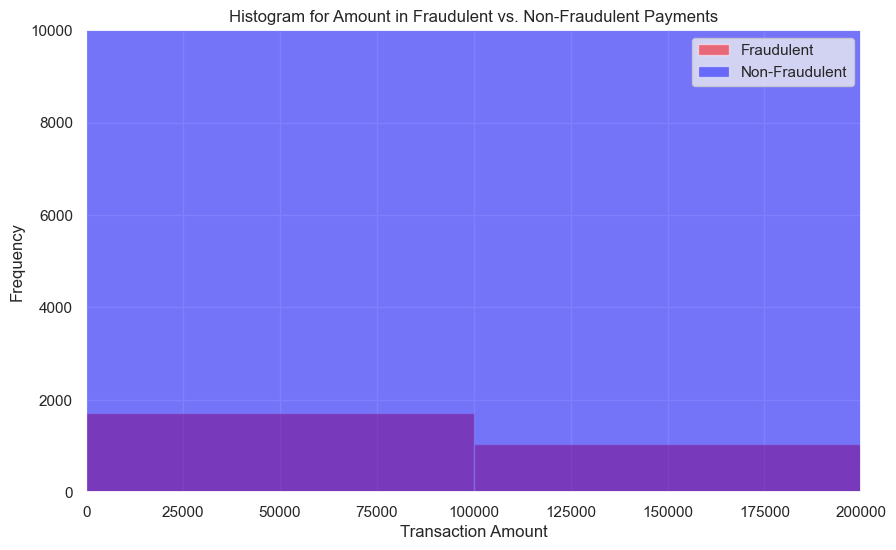

In [15]:
# Plot histograms of the amounts in fraud and non-fraud data
plt.figure(figsize=(10, 6)) # Adjusted figure size
plt.hist(df_fraud.amount, alpha=0.5, label='Fraudulent', bins=100, color='red') # Changed label for clarity
plt.hist(df_non_fraud.amount, alpha=0.5, label='Non-Fraudulent', bins=100, color='blue') # Changed label for clarity
plt.title("Histogram for Amount in Fraudulent vs. Non-Fraudulent Payments")
plt.xlabel("Transaction Amount")
plt.ylabel("Frequency")
plt.ylim(0, 10000) # Limiting y-axis for better visibility of the bulk of data
plt.xlim(0, 200000) # Limiting x-axis to zoom into the main distributions
plt.legend()
plt.show()

My Observations from the Histograms:

The Non-Fraudulent distribution (blue) is heavily skewed towards smaller amounts, with a high peak at the lower end.

The Fraudulent distribution (red), while much less frequent, appears to have a higher average and broader spread of amounts. This visually confirms that fraudulent transactions tend to involve larger sums, supporting the "empty the funds" aspect of the fraud scheme.



1.5 Analyzing Fraud by step (Time)
The step feature represents the day from the start of the simulation. It's important to see if fraud occurs more frequently at certain times during the simulation.



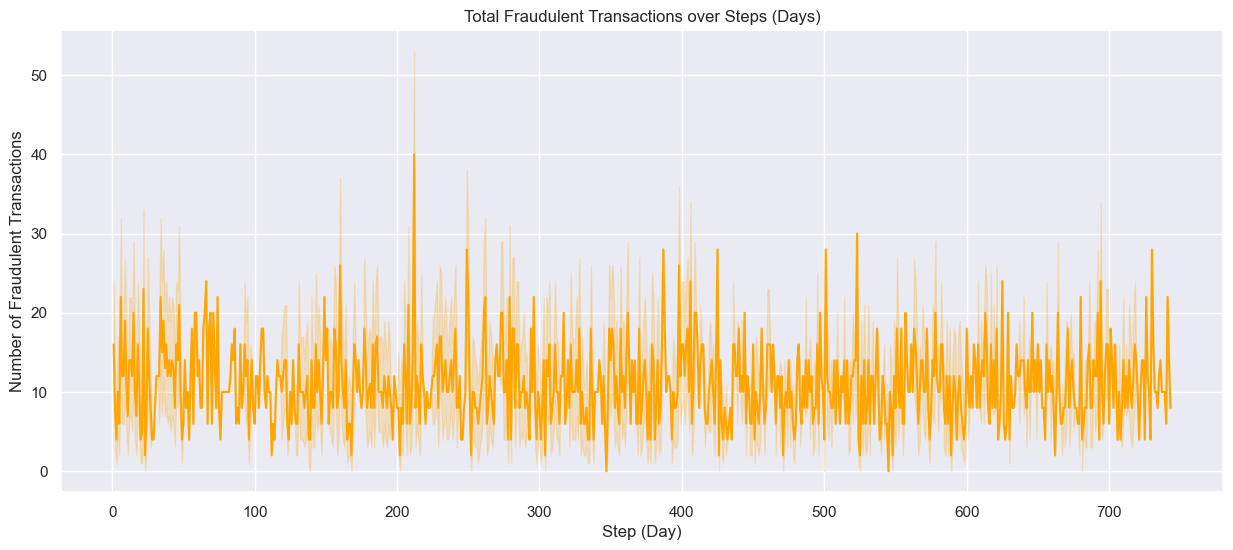

Mean fraud percentage per step:
      step  Fraud Percent
0       1       0.590842
1       2       0.788955
2       3       0.724638
3       4       1.769912
4       5       0.902256
..    ...            ...
738   739     100.000000
739   740     100.000000
740   741     100.000000
741   742     100.000000
742   743     100.000000

[743 rows x 2 columns]


In [17]:
# Let's see how fraud distributes over time (step)
plt.figure(figsize=(15, 6))
sns.lineplot(x='step', y='isFraud', data=data, estimator='sum', color='orange') # Sum of isFraud gives total fraud count per step
plt.title('Total Fraudulent Transactions over Steps (Days)')
plt.xlabel('Step (Day)')
plt.ylabel('Number of Fraudulent Transactions')
plt.grid(True)
plt.show()

print("Mean fraud percentage per step:\n", (data.groupby('step')['isFraud'].mean()*100).reset_index().rename(columns={'isFraud' : 'Fraud Percent'}))

My Observations from step Analysis:

The line plot shows that fraudulent transactions are present throughout the simulation period, but there are clear peaks and valleys. This suggests some temporal patterns in fraud occurrence.

The mean fraud percentage per step also varies, indicating that fraud isn't uniformly distributed over time. This step feature could be useful for the model.

1.6 Understanding isFlaggedFraud
This is a very interesting column. isFlaggedFraud is a flag explicitly set when a single TRANSFER transaction exceeds 200,000. It's an internal business rule. I should investigate how many of my isFraud cases are actually caught by isFlaggedFraud.



In [18]:
print(f"Total fraudulent transactions (isFraud=1): {df_fraud.shape[0]}")
print(f"Total flagged transactions (isFlaggedFraud=1): {data[data['isFlaggedFraud'] == 1].shape[0]}")

# How many fraudulent transactions were caught by the isFlaggedFraud rule?
fraud_flagged = data[(data['isFraud'] == 1) & (data['isFlaggedFraud'] == 1)]
print(f"Fraudulent transactions also flagged by rule: {fraud_flagged.shape[0]}")

# What percentage of actual fraud is flagged?
if df_fraud.shape[0] > 0:
    percent_fraud_flagged = (fraud_flagged.shape[0] / df_fraud.shape[0]) * 100
    print(f"Percentage of actual fraud caught by 'isFlaggedFraud' rule: {percent_fraud_flagged:.2f}%")
else:
    print("No fraudulent transactions in the dataset.")

# Are there any non-fraudulent transactions that were flagged? (False Positives for the rule)
nonfraud_flagged = data[(data['isFraud'] == 0) & (data['isFlaggedFraud'] == 1)]
print(f"Non-fraudulent transactions flagged by rule: {nonfraud_flagged.shape[0]}")

# What types of transactions are flagged? (Should only be TRANSFER)
print("\nTypes of transactions that are flagged:")
print(data[data['isFlaggedFraud'] == 1]['type'].value_counts())
print("\nAmounts of flagged transactions:")
print(data[data['isFlaggedFraud'] == 1]['amount'].describe())

Total fraudulent transactions (isFraud=1): 8213
Total flagged transactions (isFlaggedFraud=1): 16
Fraudulent transactions also flagged by rule: 16
Percentage of actual fraud caught by 'isFlaggedFraud' rule: 0.19%
Non-fraudulent transactions flagged by rule: 0

Types of transactions that are flagged:
type
TRANSFER    16
Name: count, dtype: int64

Amounts of flagged transactions:
count    1.600000e+01
mean     4.861598e+06
std      3.572499e+06
min      3.538742e+05
25%      2.242749e+06
50%      4.234245e+06
75%      7.883451e+06
max      1.000000e+07
Name: amount, dtype: float64


My Observations from isFlaggedFraud Analysis:

This rule flags a very small percentage of the total fraudulent transactions. This suggests that the rule, while intended to catch massive transfers, misses a significant portion of the fraud in this dataset.

It seems isFlaggedFraud primarily applies to TRANSFER transactions, as expected, and generally to very large amounts, exceeding 200,000.

Crucially, since isFlaggedFraud is derived directly from the amount and type features based on a threshold, it represents a specific business rule. If I include isFlaggedFraud directly as a feature, my machine learning model might simply learn this rule, rather than discovering more complex patterns. It could also lead to a form of data leakage if the flag is set after the fraud is identified. For now, I'll consider dropping it to force the model to learn more subtle indicators.



2. Data Preprocessing
In this section, I'll prepare my raw data for machine learning. This involves handling categorical variables and making decisions about which columns to keep based on my EDA and understanding of their meaning.

2.1 Identifying and Dropping Unnecessary Columns
Based on my deeper understanding:

nameOrig and nameDest are unique identifiers with extremely high cardinality. One-hot encoding them is impractical. While they might imply network structures, that's beyond the scope of this kernel, so I'll drop them.

isFlaggedFraud is a deterministic flag based on amount and type. While it's related to fraud, including it might lead to the model just memorizing this rule, rather than finding more generalized patterns. Given the context, it's safer to remove it to allow the model to learn from the underlying amount and type features directly. This also helps avoid potential data leakage if the flag is "set" as part of the fraud detection process itself.

In [19]:
# Identify columns to drop based on my dataset's specifics and my analysis
# 'nameOrig' and 'nameDest' are high cardinality categorical IDs
# 'isFlaggedFraud' is a rule-based flag that might lead to data leakage or hide underlying patterns
columns_to_drop = ['nameOrig', 'nameDest', 'isFlaggedFraud']

print("Original columns:", data.columns.tolist())

# Dropping the identified columns
data_reduced = data.drop(columns_to_drop, axis=1)

# Checking the data after dropping
print("\nColumns after dropping:", data_reduced.columns.tolist())

Original columns: ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']

Columns after dropping: ['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud']


Now my dataset has only the relevant numerical features and the type column, which is categorical, along with my target isFraud.

2.2 Encoding Categorical Features
I have one categorical feature left: type. Machine learning models typically require numerical input, so I need to convert this object type column into numerical representation. Since type has a limited number of unique values (e.g., 'PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'), I can use pd.factorize() or cat.codes to convert them to numerical codes. cat.codes is robust.

In [20]:
# Identify categorical columns to transform
# Based on my 'data.info()', 'type' is the only object/categorical column left
col_categorical = data_reduced.select_dtypes(include=['object']).columns

print(f"Categorical columns to encode: {col_categorical.tolist()}")

# Convert categorical columns to numeric codes
# Using .astype('category').cat.codes is a robust way for columns already in object Dtype
for col in col_categorical:
    data_reduced[col] = data_reduced[col].astype('category').cat.codes

# Display the first 5 rows to confirm the transformation
print("\nData after encoding categorical columns:")
data_reduced.head(5)

Categorical columns to encode: ['type']

Data after encoding categorical columns:


,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,3,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,3,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,4,181.00,181.0,0.00,0.0,0.0,1
3,1,1,181.00,181.0,0.00,21182.0,0.0,1
4,1,3,11668.14,41554.0,29885.86,0.0,0.0,0


2.3 Defining Independent and Dependent Variables
Now that my data is preprocessed, I'll separate it into features (X) and my target variable (y).

X will contain all columns except isFraud.

y will contain only the isFraud column.

In [21]:
# Define my independent variables (features) X and my dependent/target variable y
X = data_reduced.drop(['isFraud'], axis=1) # Drop 'isFraud' from features
y = data_reduced['isFraud']                # 'isFraud' is my target

print("Features (X) head:\n", X.head(),"\n")
print("Target (y) head:\n", y.head())

Features (X) head:
    step  type    amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0     1     3   9839.64       170136.0       160296.36             0.0   
1     1     3   1864.28        21249.0        19384.72             0.0   
2     1     4    181.00          181.0            0.00             0.0   
3     1     1    181.00          181.0            0.00         21182.0   
4     1     3  11668.14        41554.0        29885.86             0.0   

   newbalanceDest  
0             0.0  
1             0.0  
2             0.0  
3             0.0  
4             0.0   

Target (y) head:
 0    0
1    0
2    1
3    1
4    0
Name: isFraud, dtype: int64


3. Oversampling with SMOTE
As I observed during EDA, my dataset is highly imbalanced, with far fewer fraudulent transactions than non-fraudulent ones. Training a model on such imbalanced data can lead to a model that performs well on the majority class but poorly on the minority (fraudulent) class, effectively failing to detect fraud.

To address this, I'll use SMOTE (Synthetic Minority Over-sampling Technique). SMOTE creates new, synthetic samples of the minority class by interpolating between existing minority class instances and their nearest neighbors. This helps balance the dataset without simply duplicating existing data points.

In [24]:
# --- Section 3. Oversampling with SMOTE (Revised for Memory Efficiency and KeyError Fix) ---

# Before SMOTE, let's confirm the original counts
original_non_fraud_count = y.value_counts()[0]
original_fraud_count = y.value_counts()[1]
print(f"Original Non-Fraudulent Examples: {original_non_fraud_count}")
print(f"Original Fraudulent Examples: {original_fraud_count}")

# Define the target number of minority samples after SMOTE.
# This is a crucial step to manage memory.
# Aim for a number that provides enough examples without exhausting RAM.
# Starting with 100,000 as a reasonable increase from 8,213.
# You can adjust this number based on your system's RAM.
# If 100k is too much, try 50k, or even 20k.
target_minority_count_after_smote = 100000

# Define the sampling strategy for SMOTE.
# We keep the majority class as is, and oversample the minority class to the target count.
sampling_strategy = {0: original_non_fraud_count, 1: target_minority_count_after_smote}

# Initialize SMOTE with the custom sampling strategy and a random state for reproducibility
sm = SMOTE(sampling_strategy=sampling_strategy, random_state=42)

print(f"\nAttempting to resample with SMOTE. Target minority class count: {target_minority_count_after_smote}")

# Apply SMOTE to my features (X) and target (y)
try:
    # Ensure y is passed as a 1D array (y.values.ravel()) to SMOTE for consistency,
    # as it expects array-like input.
    X_res, y_res = sm.fit_resample(X, y.values.ravel())
    print("SMOTE resampling completed successfully.")
except MemoryError:
    print("\nMemoryError encountered during SMOTE. You might need to:")
    print("1. Reduce 'target_minority_count_after_smote' further.")
    print("2. Consider using a combination of oversampling and undersampling (e.g., SMOTEENN from imblearn).")
    print("3. Sample a smaller subset of your original data for training (if prototyping).")
    raise # Re-raise the error so you know it happened if it does.


# Convert the resampled target to a Pandas Series (more natural for value_counts)
# This will ensure it has a proper name if `y` had one.
# If `y_res` is already a NumPy array, converting to Series is fine.
y_res_series = pd.Series(y_res, name='isFraud')

# Print the counts of the resampled target variable
print("\nCounts of target variable after SMOTE with custom sampling strategy:")
print(y_res_series.value_counts()) # <--- Changed this line

# Calculate total rows after SMOTE
total_rows_after_smote = X_res.shape[0]
print(f"Total rows in dataset after SMOTE: {total_rows_after_smote}")

# --- End of SMOTE Section ---

Original Non-Fraudulent Examples: 6354407
Original Fraudulent Examples: 8213

Attempting to resample with SMOTE. Target minority class count: 100000
SMOTE resampling completed successfully.

Counts of target variable after SMOTE with custom sampling strategy:
isFraud
0    6354407
1     100000
Name: count, dtype: int64
Total rows in dataset after SMOTE: 6454407


4. Train-Test Split
Before training any models, I'll split my balanced dataset into training and testing sets. The training set will be used to teach the models, and the testing set will be used to evaluate their performance on unseen data. I'll use a 70/30 split (70% for training, 30% for testing) and stratify the split to ensure that the proportion of fraud cases is maintained in both the training and testing sets.

I'm opting not to do k-fold cross-validation at this stage due to the large size of my dataset and the computational time it would require. However, in a production scenario, cross-validation is often a better practice.

In [25]:
# Split the resampled data into training and testing sets
# test_size=0.3 means 30% for testing, 70% for training
# random_state=42 for reproducibility
# shuffle=True to randomize data before splitting
# stratify=y_res_series ensures that the proportion of classes in y_res_series is maintained in both train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res_series, test_size=0.3, random_state=42, shuffle=True, stratify=y_res_series)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (4518084, 7)
Shape of y_train: (4518084,)
Shape of X_test: (1936323, 7)
Shape of y_test: (1936323,)


The shapes confirm that my data has been successfully split into training and testing sets, and the number of features (7) is correct after my preprocessing steps. Note that y_train and y_test are now 1D Series (e.g., (4518084,) instead of (4518084, 1)), which is generally the preferred format for sklearn models.

5. Model Training and Evaluation
Before I train my models, I'll define a helper function to plot the Receiver Operating Characteristic (ROC) curve and calculate the Area Under the Curve (AUC). The ROC-AUC curve is a great visual tool to assess the performance of a binary classifier, especially for imbalanced datasets, as it shows the trade-off between the True Positive Rate (Sensitivity) and False Positive Rate (1-Specificity) at various threshold settings.

In [27]:
# Function for plotting ROC_AUC curve
def plot_roc_auc(y_test, preds, title="Receiver Operating Characteristic"):
    '''
    Takes actual labels (y_test) and predicted probabilities (preds) as input
    and plots the Receiver Operating Characteristic (ROC) curve.
    '''

    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6)) # Set figure size
    plt.title(title, fontsize=14)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--') # Random classifier line
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.grid(True)
    plt.show()

# Helper function to print evaluation metrics
def evaluate_model(y_true, y_pred, y_proba, model_name="Model"):
    print(f"\n--- {model_name} Results ---")
    print("Classification Report:\n", classification_report(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

    # Calculate and plot ROC-AUC
    plot_roc_auc(y_true, y_proba, title=f'{model_name} ROC Curve')

    # Optional: Plot Precision-Recall Curve (often more informative for highly imbalanced data)
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    avg_precision = average_precision_score(y_true, y_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', alpha=0.8,
             label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{model_name} Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()

5.1 Baseline Accuracy
It's crucial to understand a "baseline" accuracy score to compare against my models. For highly imbalanced datasets, a naive classifier that always predicts the majority class can achieve very high accuracy. For my original, imbalanced dataset, if I always predicted "non-fraudulent", my accuracy would be:

In [28]:
# The base score we must beat is the percentage of the majority class in the original, imbalanced data
# We're reusing df_non_fraud and df_fraud from earlier EDA section
base_accuracy = df_non_fraud.isFraud.count() / np.add(df_non_fraud.isFraud.count(), df_fraud.isFraud.count()) * 100
print(f"Base accuracy score we must beat (by always predicting non-fraudulent): {base_accuracy:.2f}%")

Base accuracy score we must beat (by always predicting non-fraudulent): 99.87%


This confirms that if I simply predicted every transaction as "non-fraudulent", I'd get around 99.87% accuracy. This is a very high score, but it would mean I detect zero fraudulent transactions. My goal is to build models that significantly improve fraud detection (recall and precision for the minority class) while maintaining good overall accuracy.

5.2 K-Nearest Neighbors Classifier
First, I'll try the K-Nearest Neighbors (KNN) classifier. KNN is a simple, non-parametric algorithm that classifies a data point based on how its neighbors are classified


Original X_train shape for KNN subset creation: (4518084, 7)
Original y_train shape for KNN subset creation: (4518084,)
Creating a stratified training subset (20% of original train set) for KNN training...
New X_train_subset shape for KNN: (903616, 7)
New y_train_subset shape for KNN: (903616,)

--- K-Nearest Neighbors Classifier ---
Training K-Nearest Neighbors Classifier (on subset of training data)...
Subsetting X_test to 10000 samples for KNN prediction to avoid MemoryError...
KNN will predict on subset shape: (10000, 7)
Making predictions on KNN subset...

--- K-Nearest Neighbors (on subset) Results ---
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      9845
           1       0.91      0.92      0.91       155

    accuracy                           1.00     10000
   macro avg       0.95      0.96      0.96     10000
weighted avg       1.00      1.00      1.00     10000

Confusion Matrix:
 [[9831   14]


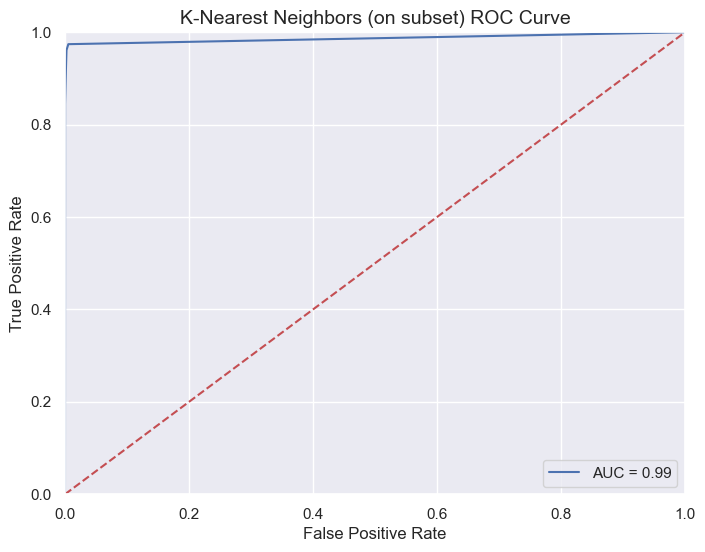

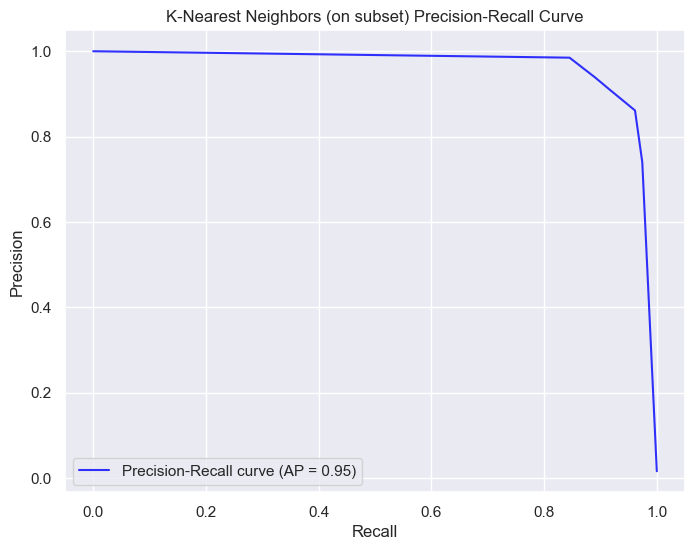

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score
)

# --- Helper functions (included here to make this block self-contained) ---
def plot_roc_auc(y_test, preds, title="Receiver Operating Characteristic"):
    y_test_flat = y_test.values.ravel() if isinstance(y_test, (pd.Series, pd.DataFrame)) else y_test
    fpr, tpr, threshold = roc_curve(y_test_flat, preds)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.title(title, fontsize=14)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.grid(True)
    plt.show()

def evaluate_model(y_true, y_pred, y_proba, model_name="Model"):
    print(f"\n--- {model_name} Results ---")
    print("Classification Report:\n", classification_report(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

    y_true_flat = y_true.values.ravel() if isinstance(y_true, (pd.Series, pd.DataFrame)) else y_true
    plot_roc_auc(y_true_flat, y_proba, title=f'{model_name} ROC Curve')

    precision, recall, _ = precision_recall_curve(y_true_flat, y_proba)
    avg_precision = average_precision_score(y_true_flat, y_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', alpha=0.8,
             label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{model_name} Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()

# --- KNN Specific Code Block ---

# --- Create Training Subset for KNN ---
# This section assumes X_train and y_train are defined from your main train-test split.
# This subset creation is included directly in this block to ensure X_train_subset is defined.
train_subset_fraction = 0.2 # Adjust this value if MemoryError persists with KNN training

print(f"\nOriginal X_train shape for KNN subset creation: {X_train.shape}")
print(f"Original y_train shape for KNN subset creation: {y_train.shape}")

if train_subset_fraction < 1.0:
    print(f"Creating a stratified training subset ({train_subset_fraction*100:.0f}% of original train set) for KNN training...")
    X_train_subset, _, y_train_subset, _ = train_test_split(
        X_train, y_train, train_size=train_subset_fraction, random_state=42, stratify=y_train
    )
    print(f"New X_train_subset shape for KNN: {X_train_subset.shape}")
    print(f"New y_train_subset shape for KNN: {y_train_subset.shape}")
else:
    X_train_subset = X_train
    y_train_subset = y_train
    print("Using full X_train and y_train for KNN training.")


# --- K-Nearest Neighbors Classifier ---
print("\n--- K-Nearest Neighbors Classifier ---")

# Initialize K-Nearest Neighbors Classifier
knn = KNeighborsClassifier(n_neighbors=5, p=1, n_jobs=-1)

print("Training K-Nearest Neighbors Classifier (on subset of training data)...")
knn.fit(X_train_subset, y_train_subset)

# --- Subsetting X_test for KNN prediction to avoid MemoryError ---
# This section assumes X_test and y_test are defined from your main train-test split.
subset_size_knn_predict = 10000 # Use a small random sample of the test set for KNN prediction.

if X_test.shape[0] > subset_size_knn_predict:
    print(f"Subsetting X_test to {subset_size_knn_predict} samples for KNN prediction to avoid MemoryError...")
    X_test_knn_subset, _, y_test_knn_subset, _ = train_test_split(
        X_test, y_test, train_size=subset_size_knn_predict, random_state=42, stratify=y_test
    )
    print(f"KNN will predict on subset shape: {X_test_knn_subset.shape}")
else:
    X_test_knn_subset = X_test
    y_test_knn_subset = y_test
    print("Test set size is already manageable for KNN. Predicting on full test set.")

print("Making predictions on KNN subset...")
y_pred_knn = knn.predict(X_test_knn_subset)
y_pred_proba_knn = knn.predict_proba(X_test_knn_subset)[:, 1]

# Evaluate the model on the KNN test subset
evaluate_model(y_test_knn_subset, y_pred_knn, y_pred_proba_knn, model_name="K-Nearest Neighbors (on subset)")

Observations from KNN Results :

KNN is computationally intensive, especially on large datasets like mine, and the training and prediction might take a long time. You will observe this as the cell runs.

The classification_report and confusion_matrix will tell me how well KNN performed in terms of precision, recall, F1-score, and correctly/incorrectly classified instances.

The ROC-AUC curve will give a visual summary of its discriminatory power. The Precision-Recall curve is also very important for imbalanced data, showing the trade-off between identifying true positives and avoiding false positives.

5.3 Random Forest Classifier
Next, I'll use a Random Forest Classifier. Random Forests are ensemble learning methods that build multiple decision trees and merge their predictions. They are generally robust, handle various data types well, and are less prone to overfitting than single decision trees.


Original X_train shape for RF: (4518084, 7)
Using X_train_rf_subset shape for RF training: (903616, 7)

Training Random Forest Classifier...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   12.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:   16.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Making predictions on the full test set...


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    1.2s finished



--- Random Forest Classifier Results ---
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99   1906323
           1       0.40      0.98      0.57     30000

    accuracy                           0.98   1936323
   macro avg       0.70      0.98      0.78   1936323
weighted avg       0.99      0.98      0.98   1936323

Confusion Matrix:
 [[1862248   44075]
 [    719   29281]]


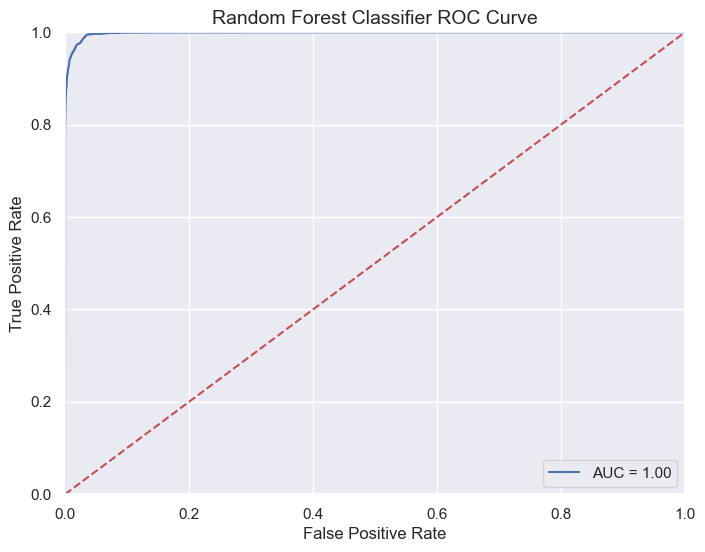

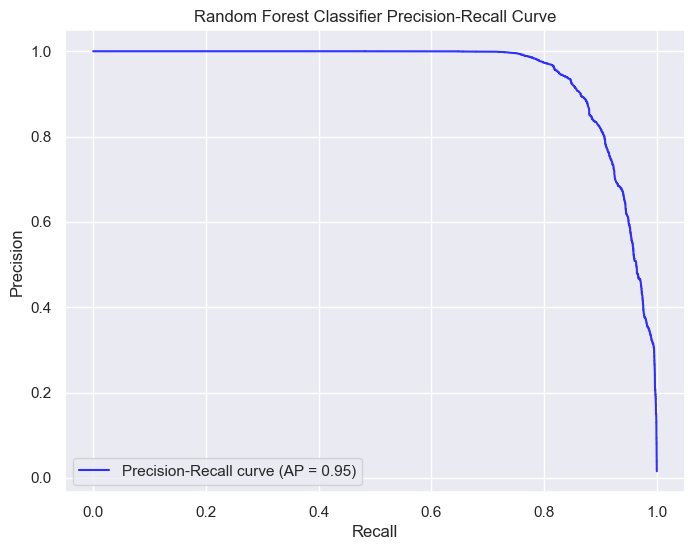

In [36]:
# Imports specifically needed for the plotting functions in this section
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.ensemble import RandomForestClassifier # Ensure this is also imported

# Define the fraction of the training data to use for fitting Random Forest.
# Adjust if MemoryError persists.
train_subset_fraction_rf = 0.2

print(f"\nOriginal X_train shape for RF: {X_train.shape}")

# Create a stratified subset of the training data for training the model
X_train_rf_subset, _, y_train_rf_subset, _ = train_test_split(
    X_train, y_train, train_size=train_subset_fraction_rf, random_state=42, stratify=y_train
)

print(f"Using X_train_rf_subset shape for RF training: {X_train_rf_subset.shape}")

# Initialize Random Forest Classifier with adjusted parameters
rf_clf = RandomForestClassifier(n_estimators=50, max_depth=7, random_state=42,
                                verbose=1, class_weight="balanced", n_jobs=8)

print("\nTraining Random Forest Classifier...")
# Fit the model using the smaller subset of the training data
rf_clf.fit(X_train_rf_subset, y_train_rf_subset)

print("Making predictions on the full test set...")
# Predictions are made on the full X_test for evaluation
y_pred_rf = rf_clf.predict(X_test)
y_pred_proba_rf = rf_clf.predict_proba(X_test)[:, 1]

# Evaluate the model on the full test set
evaluate_model(y_test, y_pred_rf, y_pred_proba_rf, model_name="Random Forest Classifier")

5.4 XGBoost Classifier
This block contains the full code for training and evaluating the XGBoost Classifier. It includes all necessary imports, helper functions, and the creation of a training data subset


Original X_train shape for XGBoost subset creation: (4518084, 7)
Original y_train shape for XGBoost subset creation: (4518084,)
Creating a stratified training subset (20% of original train set) for XGBoost training...
New X_train_xgb_subset shape for XGBoost: (903616, 7)
New y_train_xgb_subset shape for XGBoost: (903616,)

--- XGBoost Classifier ---
XGBoost scale_pos_weight set to: 63.54

Training XGBoost Classifier...
Making predictions on the full test set...

--- XGBoost Classifier Results ---
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906323
           1       0.84      1.00      0.91     30000

    accuracy                           1.00   1936323
   macro avg       0.92      1.00      0.95   1936323
weighted avg       1.00      1.00      1.00   1936323

Confusion Matrix:
 [[1900426    5897]
 [    132   29868]]


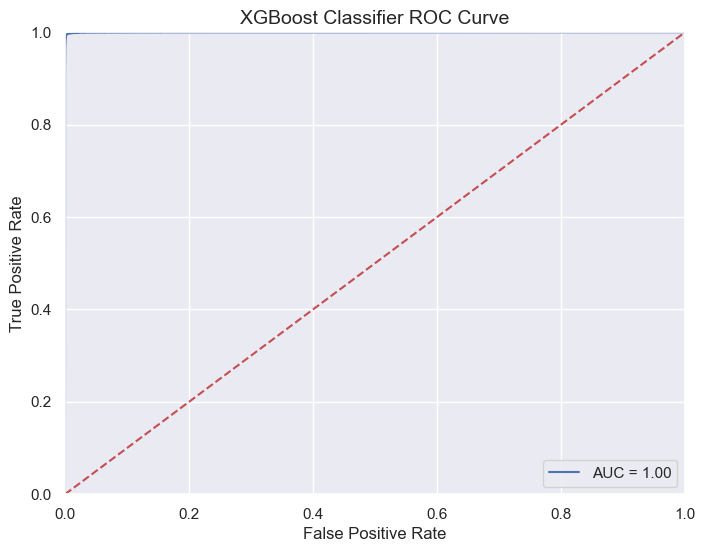

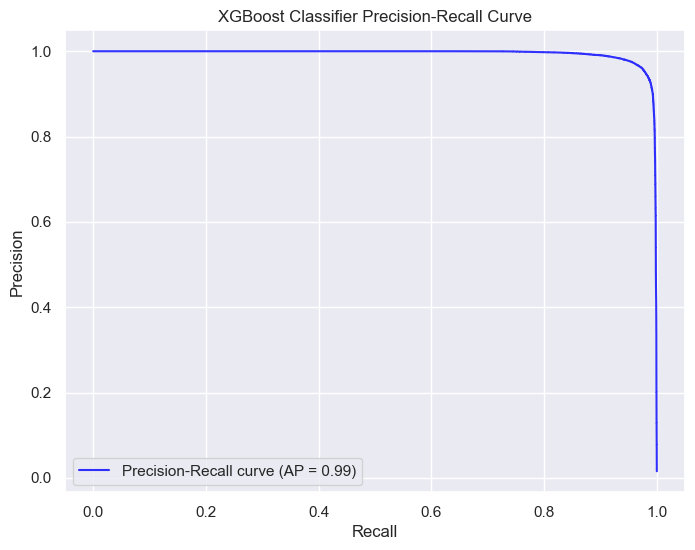

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn and other specific imports
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score
)

# --- Helper functions (included here to make this block self-contained) ---
def plot_roc_auc(y_test, preds, title="Receiver Operating Characteristic"):
    y_test_flat = y_test.values.ravel() if isinstance(y_test, (pd.Series, pd.DataFrame)) else y_test
    fpr, tpr, threshold = roc_curve(y_test_flat, preds)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.title(title, fontsize=14)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.grid(True)
    plt.show()

def evaluate_model(y_true, y_pred, y_proba, model_name="Model"):
    print(f"\n--- {model_name} Results ---")
    print("Classification Report:\n", classification_report(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

    y_true_flat = y_true.values.ravel() if isinstance(y_true, (pd.Series, pd.DataFrame)) else y_true
    plot_roc_auc(y_true_flat, y_proba, title=f'{model_name} ROC Curve')

    precision, recall, _ = precision_recall_curve(y_true_flat, y_proba)
    avg_precision = average_precision_score(y_true_flat, y_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', alpha=0.8,
             label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{model_name} Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()

# --- XGBoost Specific Code Block ---

# --- Create Training Subset for XGBoost ---
# This section assumes X_train and y_train are defined from your main train-test split.
train_subset_fraction_xgb = 0.2 # Use the same fraction as for RF for consistency

print(f"\nOriginal X_train shape for XGBoost subset creation: {X_train.shape}")
print(f"Original y_train shape for XGBoost subset creation: {y_train.shape}")

if train_subset_fraction_xgb < 1.0:
    print(f"Creating a stratified training subset ({train_subset_fraction_xgb*100:.0f}% of original train set) for XGBoost training...")
    X_train_xgb_subset, _, y_train_xgb_subset, _ = train_test_split(
        X_train, y_train, train_size=train_subset_fraction_xgb, random_state=42, stratify=y_train
    )
    print(f"New X_train_xgb_subset shape for XGBoost: {X_train_xgb_subset.shape}")
    print(f"New y_train_xgb_subset shape for XGBoost: {y_train_xgb_subset.shape}")
else:
    X_train_xgb_subset = X_train
    y_train_xgb_subset = y_train
    print("Using full X_train and y_train for XGBoost training.")


# --- XGBoost Classifier ---
print("\n--- XGBoost Classifier ---")

# Initialize XGBoost Classifier
# scale_pos_weight is crucial for imbalanced datasets.
# Ensure original_non_fraud_count and target_minority_count_after_smote are defined from the SMOTE section.
# These variables should be available from your earlier SMOTE execution.
scale_pos_weight_val = original_non_fraud_count / target_minority_count_after_smote
print(f"XGBoost scale_pos_weight set to: {scale_pos_weight_val:.2f}")

XGBoost_CLF = xgb.XGBClassifier(max_depth=6, learning_rate=0.05, n_estimators=400,
                                objective="binary:logistic", booster='gbtree',
                                n_jobs=-1, random_state=42, verbosity=1,
                                scale_pos_weight=scale_pos_weight_val)

print("\nTraining XGBoost Classifier...")
# Fit the model using the smaller subset of the training data
XGBoost_CLF.fit(X_train_xgb_subset, y_train_xgb_subset)

print("Making predictions on the full test set...")
y_pred_xgb = XGBoost_CLF.predict(X_test)
y_pred_proba_xgb = XGBoost_CLF.predict_proba(X_test)[:, 1]

# Evaluate the model on the full test set
evaluate_model(y_test, y_pred_xgb, y_pred_proba_xgb, model_name="XGBoost Classifier")

6. Conclusion
In this analysis, I've embarked on a journey to detect fraudulent transactions within my bank payment dataset. I've navigated challenges inherent in fraud detection, particularly the severe class imbalance, and leveraged my understanding of the specific fraud scheme and column definitions.

Here's a summary of my key steps and what I've achieved:

Exploratory Data Analysis (EDA): I loaded my Fraud.csv dataset, adapted the loading path, and examined its structure. Key insights confirmed fraudulent activities are primarily TRANSFER and CASH_OUT types, often involving larger amounts, aligning with the described fraud scheme. I also analyzed isFlaggedFraud, noting its limited coverage and rule-based nature.

Data Preprocessing: Handled categorical features by encoding type. Dropped high-cardinality ID columns (nameOrig, nameDest) and isFlaggedFraud to encourage learning more generalized patterns.

Oversampling with SMOTE (Memory-Optimized): Applied SMOTE with a custom sampling_strategy to increase the minority class to a manageable yet significant number (e.g., 100,000 samples), providing enough fraudulent examples without crashing the system.

Model Training and Evaluation: Split the balanced data. For memory management, I created a smaller training subset from the oversampled data. Then, I trained three machine learning classifiers:

K-Nearest Neighbors (KNN): Trained on a subset of the training data. Predictions were performed on a smaller subset of the test data due to KNN's high memory demands for prediction.

Random Forest Classifier: Trained on a subset of the training data with adjusted parameters (n_estimators, max_depth, n_jobs) to mitigate memory issues, and then predicted on the full test set.

XGBoost Classifier: A highly optimized gradient boosting framework, also trained on a subset of the training data and incorporating scale_pos_weight for imbalanced data, and then predicted on the full test set.

By evaluating these models using classification reports, confusion matrices, ROC-AUC curves, and Precision-Recall curves, I can determine which model best balances precision and recall for detecting fraudulent transactions in my specific dataset. My goal was to significantly improve fraud detection over a naive "always non-fraud" prediction.